## Problem 15: "Advanced" Pandemic Flu Spread

Project 3 considered a (trivial) discrete-event simulation of pandemic flu spread in a classroom. (Project 4 concerned a continuous-time, deterministic simulation that doesn’t apply here.) If you feel a little more adventuresome, I’d like you to think about a bigger-and-better simulation involving a larger population. Here’s a potential scenario (there are many other interesting ones — feel free to be imaginative):

- Some infectious people enter a population of susceptibles, and some of the susceptibles become infected.
- There is a short period of a couple of days before a newly-infected person in turn becomes infectious.
- When a person recovers (or dies), the person is not again susceptible.
- Infectiousness or death can be mitigated by masking, social distancing, etc.
- Infectiousness or death can be mitigated by vaccination. Vaccines can be delivered in one or two doses. But there could be supply chain issues.
- Even if a vaccine requires two doses, the vaccine nevertheless provides partial immunization after even only one dose. Might you immediately give everyone only one dose instead of two, and hope that the supply chain catches up so that you can “eventually” give everyone two doses?

To determine whether a particular strategy is any good, you probably ought to consider the number of people who eventually get infected (or die), the length of the epidemic, etc.


In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys

# Get the current working directory (where the notebook is located)
current_dir = os.getcwd()

# Construct the path to the src folder
src_path = os.path.join(current_dir, "src")

# Add src_path to sys.path
sys.path.insert(0, src_path)

In [ ]:
from src.batch_run import SimulationBatchRunner
from src.policies import (
    basic_vaccination_policy,
    mask_policy,
    vulnerable_distancing_policy,
)

In [4]:
# Define simulation parameters
simulation_params = {
    "population_size": 10_000,  # Total number of individuals in the simulation.
    "initial_infected": 0.01,  # If int, the number of individuals initially infected. If float between 0 and 1, the fraction of the population initially infected.
    "infection_rate": 0.01,  # Base infection probability per contact.
    "incubation_period": 2,  # Number of days before becoming infectious.
    "infectious_period": 5,  # Number of days an individual remains infectious.
    "base_contacts": 10,  # Number of contacts per day for non-social distancing individuals.
    "social_distancing_rate": 0.3,  # Rate to reduce contacts for social distancing individuals.
    "mortality_rate": 0.01,  # Probability of dying from the disease (0 <= mortality_rate <= 1).
    "mask_policy": mask_policy,  # Function implementing the mask-wearing policy.
    "distancing_policy": vulnerable_distancing_policy,  # Function implementing the social distancing policy.
    "vaccination_policy": basic_vaccination_policy,  # Function implementing the vaccination strategy.
    "random_seed": 42,  # Seed for the random number generator.
}

# Number of simulation runs
num_runs = 100

# Create the SimulationBatchRunner
batch_runner = SimulationBatchRunner(
    num_runs=num_runs,
    simulation_params=simulation_params,
)

# Run all simulations
batch_runner.run()

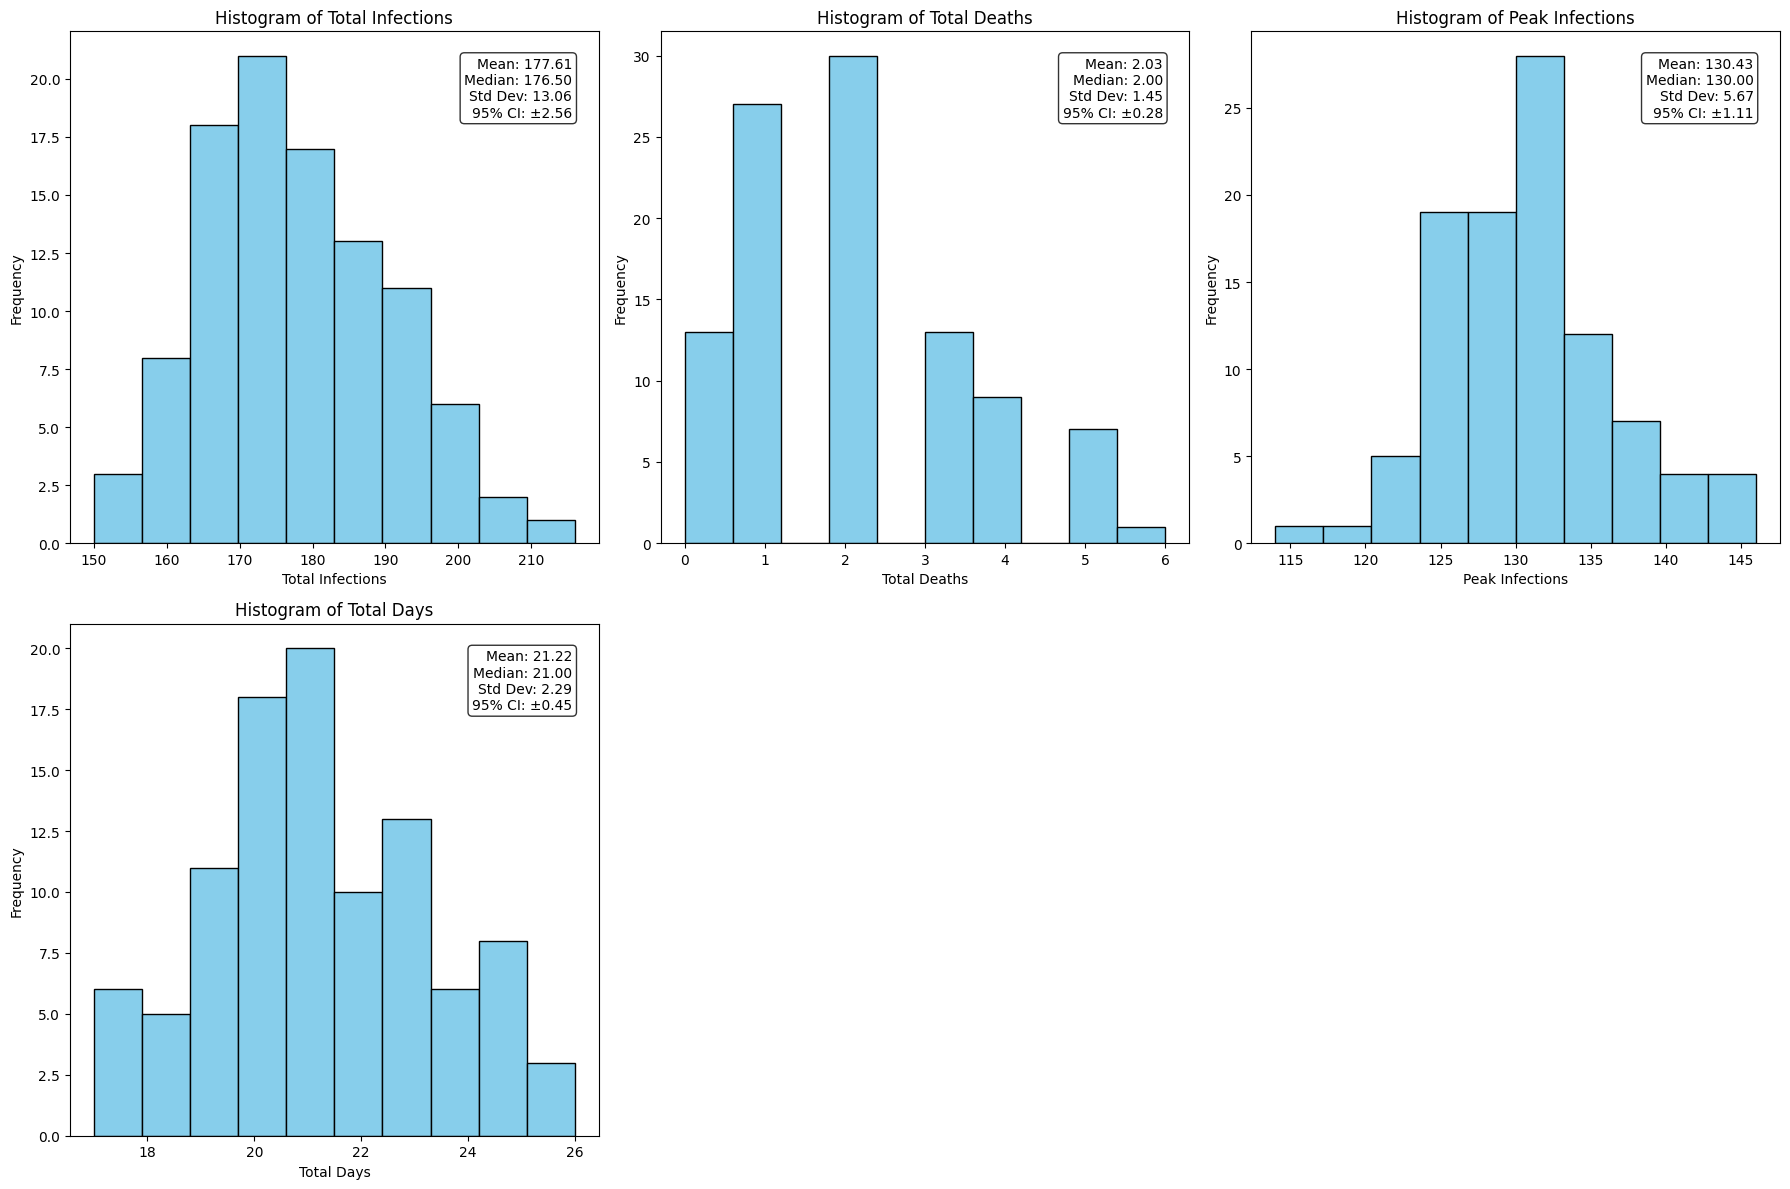

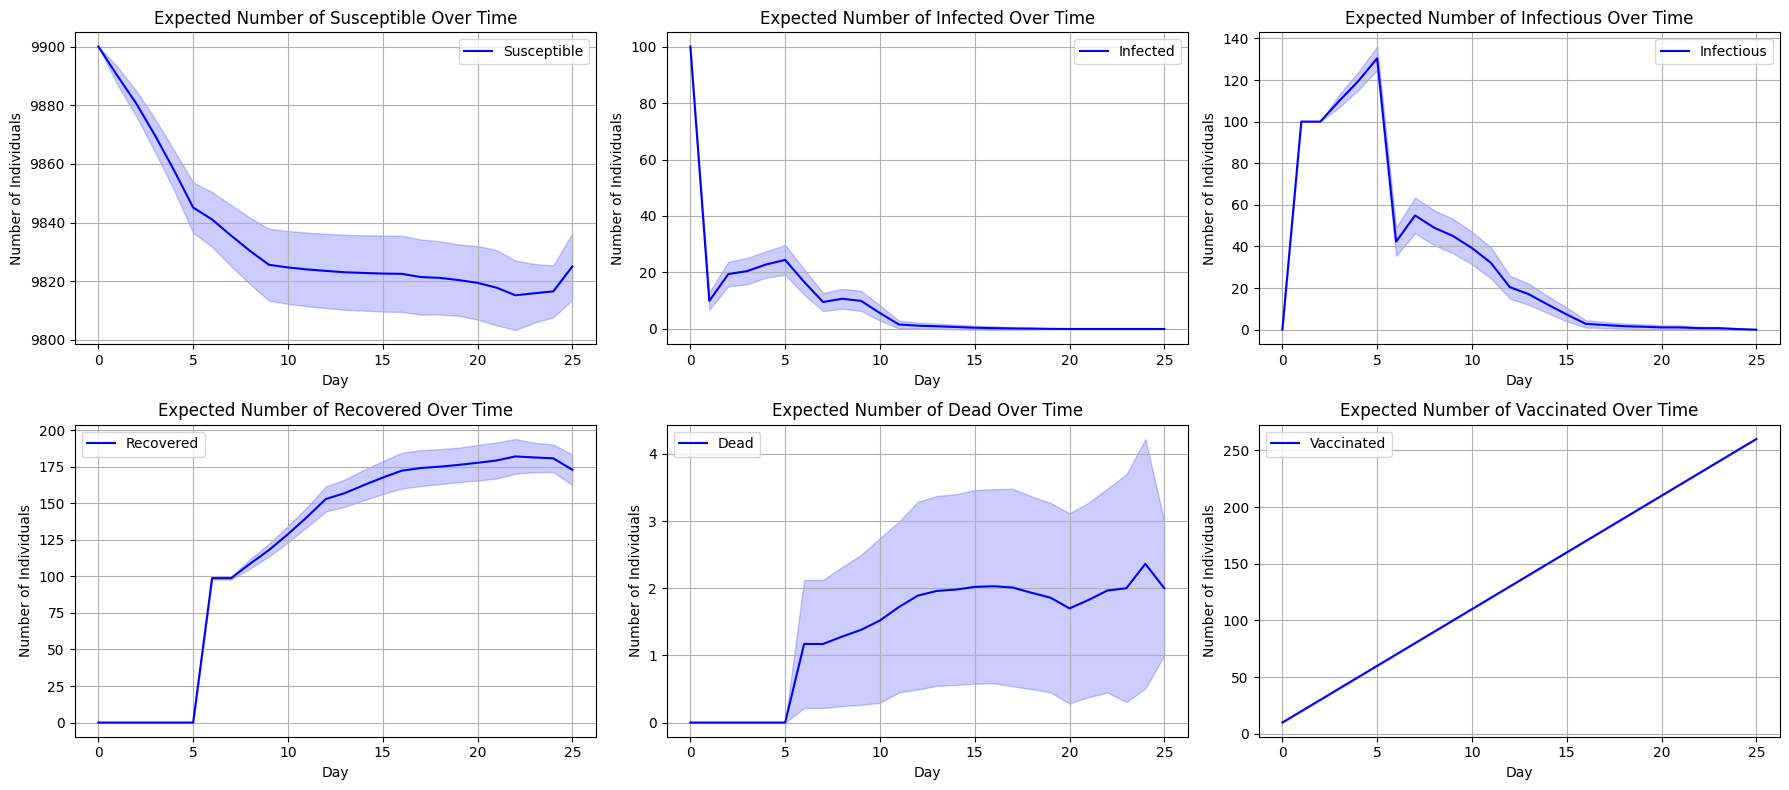

In [ ]:
# Plot histograms with statistical summaries
batch_runner.plot_histograms()

# Plot the expected counts over time
batch_runner.plot_state_histograms()